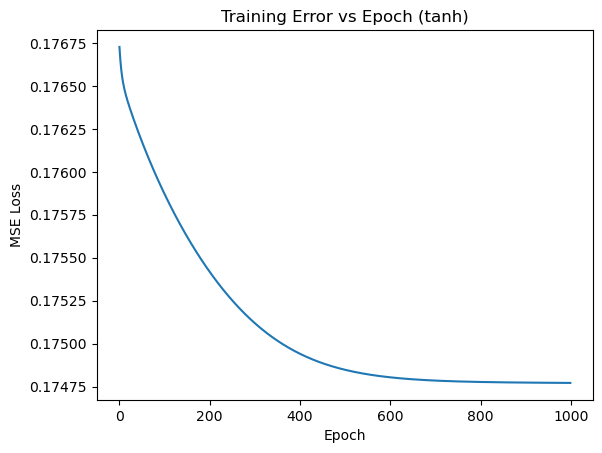

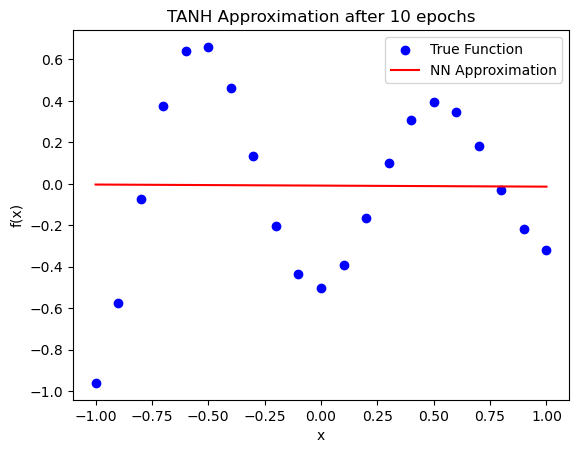

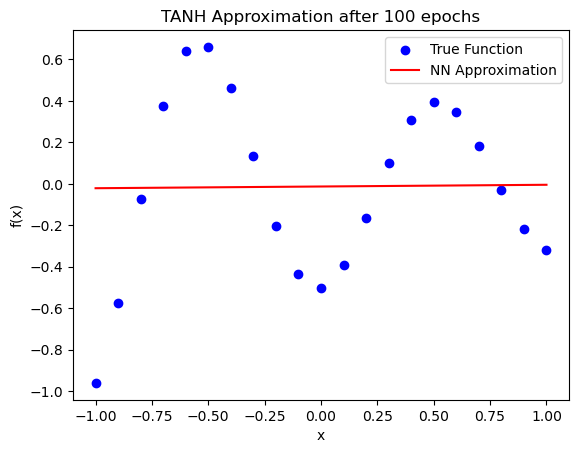

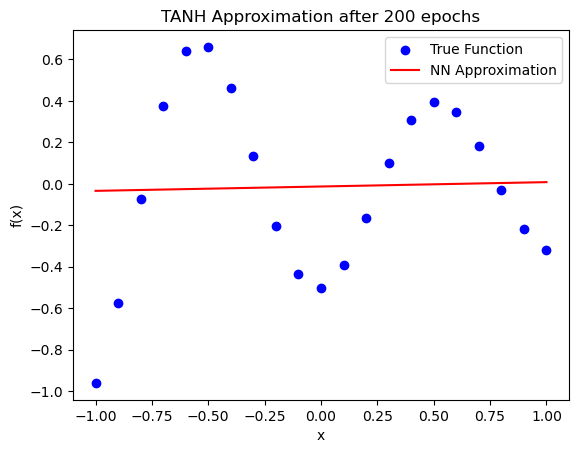

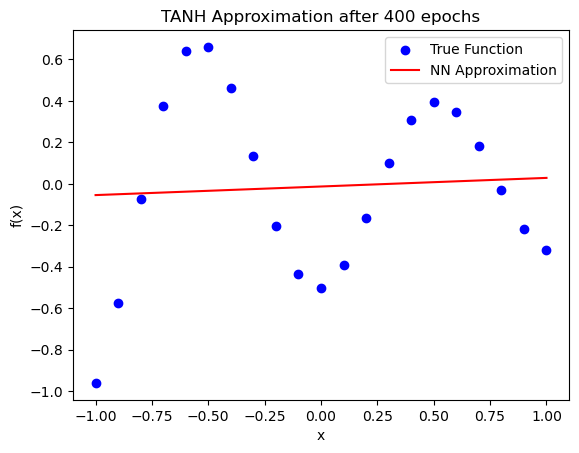

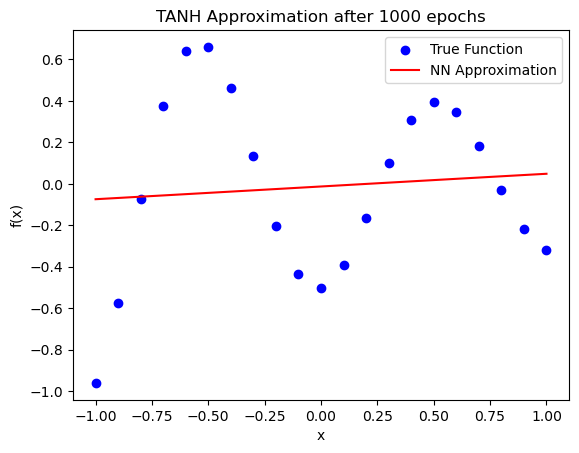

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ==================================================
# Two-Layer Neural Network with Switchable Activations
# ==================================================
# Input (1) -> Hidden Layer (H neurons) -> Output (1)
# Supports: tanh, sigmoid (logsig), ReLU, RBF
# Backpropagation coded manually (no ML packages)
# ==================================================

# ----------------------------
# 1. Define activation functions
# ----------------------------
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

# Radial Basis Function (Gaussian)
def rbf(x, centers, sigma=0.5):
    # x: (1,N), centers: (H,1)
    return np.exp(-((x - centers)**2) / (2 * sigma**2))

# ----------------------------
# 2. Dataset (from question)
# ----------------------------
X = np.linspace(-1, 1, 21).reshape(1, -1)
Y = np.array([[-0.96, -0.577, -0.073, 0.377, 0.641, 0.66, 0.461, 0.134, -0.201,
               -0.434, -0.5, -0.393, -0.165, 0.099, 0.307, 0.396, 0.345, 0.182,
               -0.031, -0.219, -0.321]])

# ----------------------------
# 3. Training function with flexible activation
# ----------------------------
def train_nn(X, Y, activation="tanh", H=5, lr=0.05, epochs=1000):
    np.random.seed(42)

    # Initialize parameters
    W1 = np.random.randn(H, 1) * 0.1
    b1 = np.zeros((H, 1))
    W2 = np.random.randn(1, H) * 0.1
    b2 = np.zeros((1, 1))

    # For RBF: hidden layer is fixed basis functions (not trained)
    if activation == "rbf":
        centers = np.linspace(-1, 1, H).reshape(H, 1)
        sigma = 0.3

    errors = []
    snapshots = {10: None, 100: None, 200: None, 400: None, 1000: None}

    for epoch in range(1, epochs+1):
        # ---- Forward pass ----
        if activation == "tanh":
            Z1 = np.dot(W1, X) + b1
            A1 = tanh(Z1)
            dA1_dZ1 = tanh_derivative(Z1)
        elif activation == "sigmoid":
            Z1 = np.dot(W1, X) + b1
            A1 = sigmoid(Z1)
            dA1_dZ1 = sigmoid_derivative(Z1)
        elif activation == "relu":
            Z1 = np.dot(W1, X) + b1
            A1 = relu(Z1)
            dA1_dZ1 = relu_derivative(Z1)
        elif activation == "rbf":
            A1 = rbf(X, centers, sigma)
            dA1_dZ1 = None  # RBF not trained in hidden layer

        Z2 = np.dot(W2, A1) + b2
        Y_pred = Z2  # Linear output for regression

        # ---- Loss (MSE) ----
        loss = np.mean((Y_pred - Y)**2)
        errors.append(loss)

        # ---- Backprop ----
        dL_dY = 2 * (Y_pred - Y) / X.shape[1]

        dW2 = np.dot(dL_dY, A1.T)
        db2 = np.sum(dL_dY, axis=1, keepdims=True)

        if activation != "rbf":
            dA1 = np.dot(W2.T, dL_dY)
            dZ1 = dA1 * dA1_dZ1
            dW1 = np.dot(dZ1, X.T)
            db1 = np.sum(dZ1, axis=1, keepdims=True)

            W1 -= lr * dW1
            b1 -= lr * db1

        W2 -= lr * dW2
        b2 -= lr * db2

        # Save snapshots
        if epoch in snapshots:
            snapshots[epoch] = (W1.copy(), b1.copy(), W2.copy(), b2.copy(), centers if activation=="rbf" else None)

    return errors, snapshots

# ----------------------------
# 4. Forward pass utility (for plotting)
# ----------------------------
def forward_pass(X, params, activation="tanh"):
    W1, b1, W2, b2, centers = params
    if activation == "tanh":
        A1 = tanh(np.dot(W1, X) + b1)
    elif activation == "sigmoid":
        A1 = sigmoid(np.dot(W1, X) + b1)
    elif activation == "relu":
        A1 = relu(np.dot(W1, X) + b1)
    elif activation == "rbf":
        A1 = rbf(X, centers, 0.3)
    return np.dot(W2, A1) + b2

# ----------------------------
# 5. Run training for one activation (example: tanh)
# ----------------------------
activation_choice = "tanh" # change to "sigmoid", "relu", or "rbf", or "tanh"
errors, snapshots = train_nn(X, Y, activation=activation_choice, H=5)

# Plot training error
plt.plot(errors)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Training Error vs Epoch ({activation_choice})")
plt.show()

# Plot approximation results at milestones
for e, params in snapshots.items():
    Y_hat = forward_pass(X, params, activation=activation_choice)
    plt.scatter(X.flatten(), Y.flatten(), c='blue', label='True Function')
    plt.plot(X.flatten(), Y_hat.flatten(), 'r-', label='NN Approximation')
    plt.title(f"{activation_choice.upper()} Approximation after {e} epochs")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.show()